<a href="https://colab.research.google.com/github/estevaosmith/Portifolio/blob/main/PROJETO_S%C3%A9ries_temporais_para_um_abrigo_de_animais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Previsão de Séries Temporais com o Prophet

## Prophet e Séries Temporais

Produzir previsões precisas com dados temporais é uma desafio de grande complexidade. Dada a natureza dos modelos estatísticos, séries temporais apresentam um desafio para profissionais em áreas como engenharia de machine learning, estatística e economia.

Tentar desenvolver um modelo sem recorrer a nenhum framework implica uma compreensão aprofundada de uma teoria que não é simples, demandando um nível significativo de especialização.

 O Prophet é uma ferramenta de código aberto desenvolvida pelo Facebook(agora Meta) para previsão de séries temporais. Ele foi projetado para ser fácil de usar e eficaz, especialmente para prever séries temporais que exibem sazonalidade e tendências não lineares.

<p align="center"><img src="https://upload.wikimedia.org/wikipedia/commons/0/0b/Series-Temporal-Aleatoria-Sazonal.png" height="400px"></p>

### Modelo Preditivo do Prophet

Conforme mencionado anteriormente, o Prophet foi desenvolvido para abordar desafios específicos encontrados no Facebook. Isso significa que é particularmente eficaz para lidar com problemas que apresentem as seguintes características:

- Conjuntos de dados coletados ao longo de um período prolongado (meses ou anos), com um histórico detalhado.
- Presença de sazonalidades distintas e pronunciadas.
- Inclusão de feriados ou datas especiais conhecidas com antecedência.
- Tendência de crescimento não linear, que se aproxima de um limite.

O Prophet emprega um modelo de séries temporais decomposto em três componentes principais: tendência, sazonalidade e feriados.
$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

onde:

* $g(t)$ é a tendência, que modela as mudanças não-periódicas no valor da série temporal;
* $s(t)$ representa as mudanças periódicas (como sazonalidade semanal, anual, etc);
* $h(t)$ representa os efeitos dos feriados; e
* $\varepsilon_t$ é o erro, as mudanças que não são capturadas pelo modelo (assume-se esse como tendo uma distribuição normal).

Lembrando, os parâmetros que estão definidos como *standard* atendem bem a maioria dos casos. No entanto, caso não tenham um *fit* adequado ao seu problema, esses podem ser ajustados manualmente.


## O Problema de um Abrigo de Animais

O Centro de Animais de Austin, no Texas, abriga mais de 16 mil animais por ano e oferece diversos serviços relacionados à proteção dos animais, sem distinção de raça, idade ou estado de saúde.

O principal objetivo é "encaminhar o maior número possível de animais para novos lares, seja por meio de adoção, assistência social ou grupos de resgate".

Apesar dessa meta, nem sempre é viável encontrar lares para todos esses animais, e muitos acabam sendo sacrificados. O objetivo do Austin Animal Center é alcançar um índice de sucesso, ou seja, a sobrevivência desses animais, superior a 90% do total.

Neste projeto, analisaremos os resultados da permanência desses animais no centro. Por meio dessa análise, esperamos identificar padrões de adoção.

Além de identificar padrões, almejamos fazer previsões futuras sobre o número de saídas do Austin Animal Center, visando:

1. Planejar a compra de insumos (medicamentos, comida, etc.);
2. Contratar funcionários e colaboradores; e
3. Lançar campanhas visando otimizar a adoção de animais.

### Aquisição dos Dados

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O *dataset* usado neste *notebook* foi atualizado em 30 de abril de 2020 e contém **117K linhas** e **12 colunas**

In [1]:
# importar as bibliotecas necessárias
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# importar os dados para um DataFrame
df = pd.read_csv("https://github.com/carlosfab/escola-data-science/blob/master/datasets/shelter_animal_outcomes.csv?raw=true")

# converter a coluna DateTime para o formato conveniente
df.DateTime = pd.to_datetime(df.DateTime)

# ver as primeiras 5 entradas
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


### Análise Exploratória
Antes de partirmos para o modelo de series temporais, vamos realizar uma pequena análise exploratória

In [3]:
# ver o resumo das principais informações estatísticas
df.describe()

,DateTime
count,117416
mean,2016-12-29 16:48:02.591810560
min,2013-10-01 09:31:00
25%,2015-05-22 11:24:15
50%,2016-12-17 11:53:00
75%,2018-08-26 18:03:45
max,2020-04-30 18:54:00


FALAR BREVEMENTE SOBRE O RESUMO ESTATÏSTICO

In [4]:
# ver um resumo dos tipos de variáveis e valores não-nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117416 entries, 0 to 117415
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         117416 non-null  object        
 1   Name              80599 non-null   object        
 2   DateTime          117416 non-null  datetime64[ns]
 3   MonthYear         117416 non-null  object        
 4   Date of Birth     117416 non-null  object        
 5   Outcome Type      117408 non-null  object        
 6   Outcome Subtype   53247 non-null   object        
 7   Animal Type       117416 non-null  object        
 8   Sex upon Outcome  117413 non-null  object        
 9   Age upon Outcome  117369 non-null  object        
 10  Breed             117416 non-null  object        
 11  Color             117416 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 10.7+ MB


In [5]:
# verificar se há dados ausentes
df.isnull().sum()

Animal ID               0
Name                36817
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            8
Outcome Subtype     64169
Animal Type             0
Sex upon Outcome        3
Age upon Outcome       47
Breed                   0
Color                   0
dtype: int64

Os dados estão, na medida do possível, bem presentes, faltando apenas os nomes dos animais e os subtipos de saídas, então vamos desconsiderá-los na análise

In [6]:
# ver os tipos de outcomes possíveis
tipos_outcome = df['Outcome Type'].value_counts()

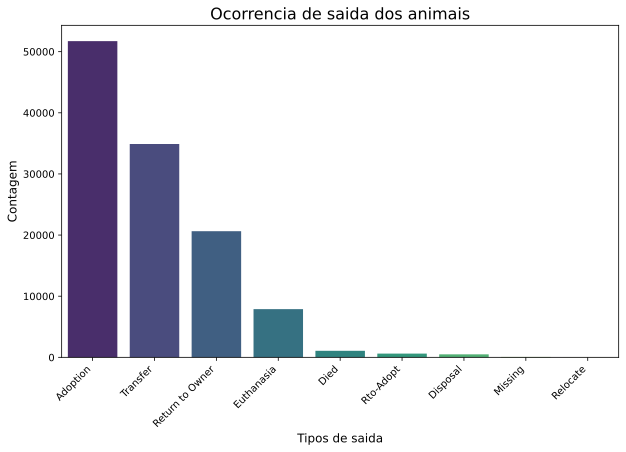

In [7]:
# Plotando o grafico com a biblioteca seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=tipos_outcome.index, y=tipos_outcome.values, palette='viridis')

plt.xlabel('Tipos de saida', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.title('Ocorrencia de saida dos animais', fontsize=16)


plt.xticks(rotation=45, ha='right')

plt.show()

Como podem ver, adoção e transferência são a maioria dos tipos de saída de animais, enquanto a eutanásia e a devolução para o dono estão em segundo plano

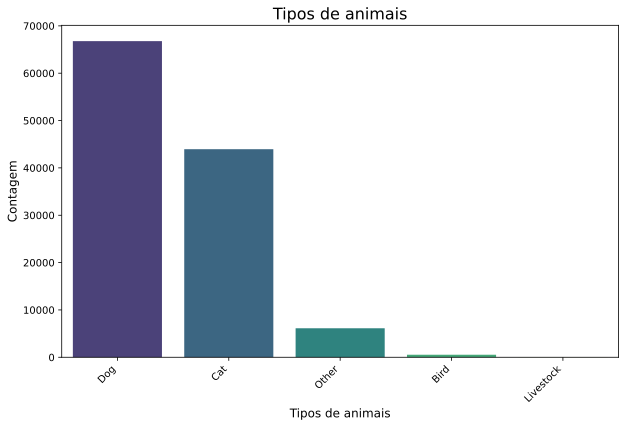

In [8]:
# Plotando o grafico com a biblioteca seaborn
animais = df['Animal Type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=animais.index, y=animais.values, palette='viridis')

plt.xlabel('Tipos de animais', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.title('Tipos de animais', fontsize=16)


plt.xticks(rotation=45, ha='right')

plt.show()

Outro fato interessante é que o abrigo possui uma grande maioria de cachorros, seguidos de gatos.

Agora, vamos ver em que época do ano ocorrem mais adoçãos.

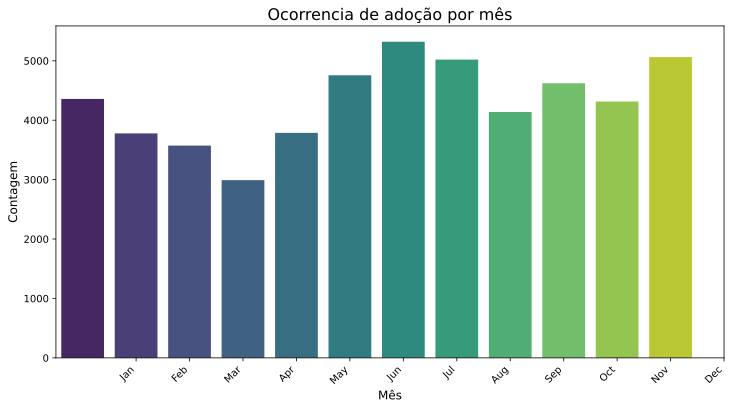

In [9]:
import calendar
df['Month'] = df['DateTime'].dt.month

adoptions = df[df['Outcome Type'] == 'Adoption']

monthly_adoptions = adoptions.groupby('Month').size().reset_index(name='Count')

# Plotando o grafico com o seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Count', data=monthly_adoptions, palette='viridis')

plt.xlabel('Mês', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.title('Ocorrencia de adoção por mês', fontsize=16)

plt.xticks(monthly_adoptions['Month'].unique(), [calendar.month_abbr[month] for month in monthly_adoptions['Month'].unique()], rotation=45, ha='right')

plt.show()

As adoções ocorrem principalmente nos meses de verão nos Estados Unidos, entre maio e agosto. Uma das hipóteses seria as férias escolares, porém seria necessário um estudo mais aprofundado para alguma comprovação

### Modelo de previsão com o Prophet
#### Modelo Diário
O Prophet é uma poderosa ferramenta do Meta (anteriormente Facebook) que permite a previsão de valores futuros, sejam eles diários, semanais ou anuais.

Para começar, vamos projetar os resultados para um ano após o fim do conjunto de dados (2020).

In [35]:
adoptions_df = df[(df['Outcome Type'] == 'Adoption')]
adoptions_df['outcomeCount'] = 1

adoptions_df = adoptions_df[['DateTime', 'outcomeCount']]
adoptions_df = adoptions_df.set_index('DateTime').sort_index()
adoptions_df.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:42:00,1
2013-10-01 11:53:00,1
2013-10-01 11:53:00,1
2013-10-01 15:47:00,1


In [36]:
# trabalhar com dados diários
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime':'ds', 'outcomeCount':'y'})

# ver as 5 primeiras entradas
prophet_df.head()

,ds,y
0,2013-10-01,11
1,2013-10-02,16
2,2013-10-03,10
3,2013-10-04,11
4,2013-10-05,36


In [ ]:
# instanciar e treinar o modelo
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(prophet_df)

# determinar o período de dias para previsão
future = model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

In [38]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds       yhat  yhat_lower  yhat_upper
2764 2021-04-26  13.401508   -0.856591   26.499576
2765 2021-04-27  14.672606    0.617643   28.729829
2766 2021-04-28  12.347392   -1.497128   26.829545
2767 2021-04-29  12.054967   -1.104957   26.041301
2768 2021-04-30  14.093265    0.368487   27.458594


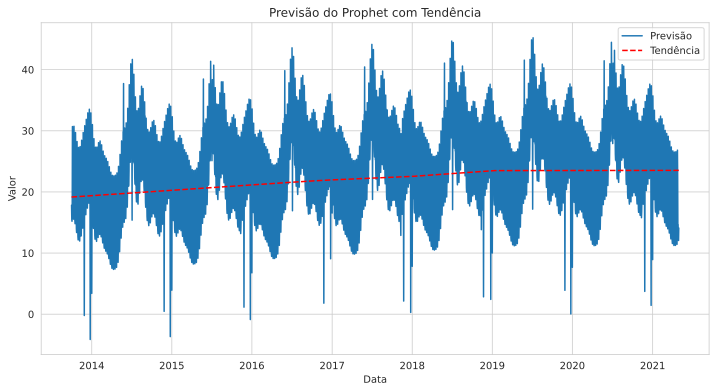

In [52]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='yhat', data=forecast, label='Previsão')
sns.lineplot(x='ds', y='trend', data=forecast, color='red', linestyle='--', label='Tendência')
plt.title('Previsão do Prophet com Tendência')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

Como podem ver pela inclinação da reta, as adoções apresentam uma leve tendência de alta

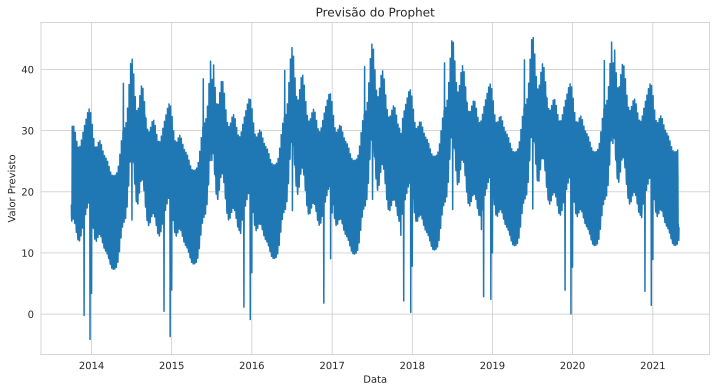

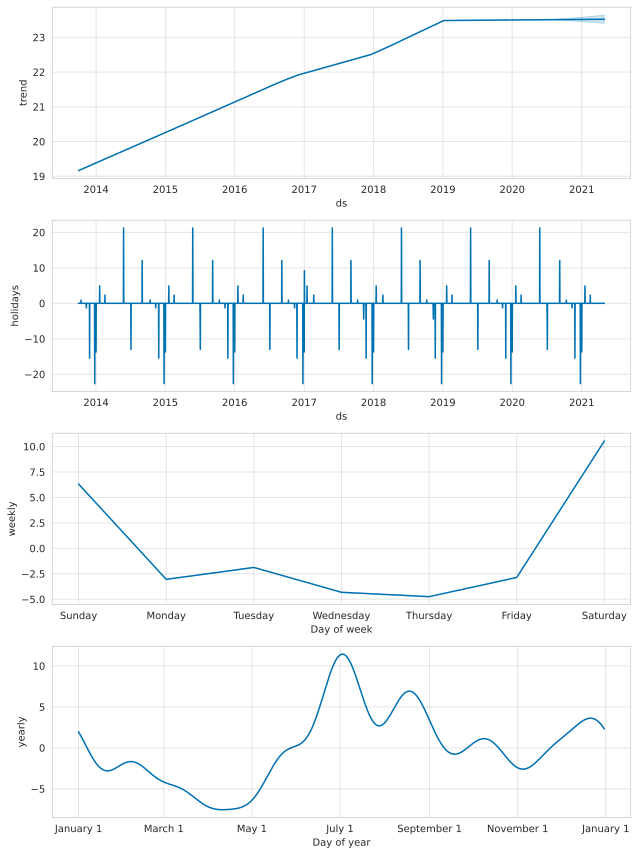

In [51]:
from prophet.plot import plot_plotly, plot_components_plotly


plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='yhat', data=forecast)
plt.title('Previsão do Prophet')
plt.xlabel('Data')
plt.ylabel('Valor Previsto')
plt.grid(True)


fig = model.plot_components(forecast)

plt.show()
fig.show()

Sábado e domingo são os dias da semana com mais adoções, e no feriado de 1º de julho, o Dia da Independência Americana, as adoções atingem o pico.

### Avaliação do Modelo de Séries Temporais

In [55]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv.head()

INFO:prophet:Making 6 forecasts with cutoffs between 2016-10-30 12:00:00 and 2019-05-01 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyw0i_23r/pwbnaac9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyw0i_23r/ooi2bpvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18998', 'data', 'file=/tmp/tmpyw0i_23r/pwbnaac9.json', 'init=/tmp/tmpyw0i_23r/ooi2bpvd.json', 'output', 'file=/tmp/tmpyw0i_23r/prophet_modeliit4aq0s/prophet_model-20240423212545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyw0i_23r/7ugzbcs0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyw0i_23r/wbr5huq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-31,15.607905,2.751460,26.878153,16,2016-10-30 12:00:00
1,2016-11-01,16.135583,5.144844,28.107458,16,2016-10-30 12:00:00
2,2016-11-02,14.085036,1.613499,25.425443,13,2016-10-30 12:00:00
3,2016-11-03,13.709763,1.738175,26.393638,21,2016-10-30 12:00:00
4,2016-11-04,14.630627,3.653592,26.643958,26,2016-10-30 12:00:00


from matplotlib import pyplot as plt
_df_0['yhat'].plot(kind='hist', bins=20, title='yhat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['yhat_lower'].plot(kind='hist', bins=20, title='yhat_lower')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['yhat_upper'].plot(kind='hist', bins=20, title='yhat_upper')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='yhat', y='yhat_lower', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='yhat_lower', y='yhat_upper', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='yhat_upper', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat_lower']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat_lower')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat_upper']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat_upper')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
_df_11['yhat'].plot(kind='line', figsize=(8, 4), title='yhat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['yhat_lower'].plot(kind='line', figsize=(8, 4), title='yhat_lower')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['yhat_upper'].plot(kind='line', figsize=(8, 4), title='yhat_upper')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

In [56]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,36 days 12:00:00,96.711520,9.834202,7.191181,0.262281,0.350939,0.853881
1,37 days 00:00:00,96.598239,9.828440,7.178242,0.262281,0.349652,0.853881
2,37 days 12:00:00,97.546113,9.876544,7.269998,0.269913,0.354349,0.853881
3,38 days 00:00:00,97.036664,9.850719,7.250979,0.270317,0.353739,0.853881
4,38 days 12:00:00,96.680502,9.832624,7.222235,0.269913,0.351405,0.858447


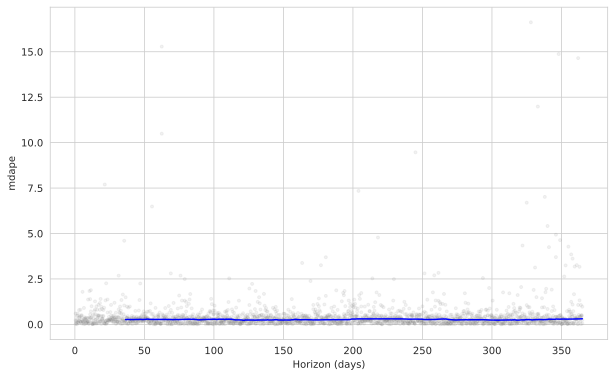

In [57]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mdape')

Novamente a tendencia de alta na adoção fica evidente no grafico acima

### Feriados e Datas Comemorativas

In [59]:
# Feriados e datas personalizadas
personalizado = pd.DataFrame({
    'holiday': 'Seu Feriado Aqui',
    'ds': pd.to_datetime(['2018-02-07', '2019-02-07', '2020-02-07']),
    'lower_window': 0,
    'upper_window': 1,
})

model = Prophet(holidays=personalizado)
model.add_country_holidays(country_name='US')
model.fit(prophet_df)
model.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyw0i_23r/lpvc3os5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyw0i_23r/lvr0bk9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22111', 'data', 'file=/tmp/tmpyw0i_23r/lpvc3os5.json', 'init=/tmp/tmpyw0i_23r/lvr0bk9x.json', 'output', 'file=/tmp/tmpyw0i_23r/prophet_modelhtyb555w/prophet_model-20240423213252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0                Seu Feriado Aqui
1                  New Year's Day
2                    Memorial Day
3                Independence Day
4                       Labor Day
5                    Veterans Day
6                    Thanksgiving
7                   Christmas Day
8        Christmas Day (observed)
9      Martin Luther King Jr. Day
10          Washington's Birthday
11                   Columbus Day
12      New Year's Day (observed)
13        Veterans Day (observed)
14    Independence Day (observed)
dtype: object

Confirmado a hipótese acima, o Dia da Independência teve o maior desempenho em adoções, seguido pelo Dia dos Veteranos e pelo Ano Novo.

## Conclusão
Apesar deste projeto ser relativamente simples,a utilização do Prophet facilitou o processo de modelagem e previsão, especialmente em séries temporais com sazonalidade e tendências não lineares.

Ficou claro  que as adoções ocorrem principalmente nos meses de verão nos Estados Unidos, entre maio e agosto, com um pico durante o feriado de 1º de julho, o Dia da Independência Americana. Esses insights são valiosos para planejar estratégias de adoção, planejar compras de insumos e otimizar o funcionamento do abrigo.

Enfim, o objetivo deste projeto é destacar a importância da análise de dados e previsão em contextos do mundo real, como o abrigo de animais, para melhorar a eficiência das operações.







